In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import sys
import os
import json
import pandas as pd

sys.path.insert(0, '/home/garren/HPC Files/Pure RK PMF')

from Post_procs import Post_process

/tmp/ipykernel_760622/2764910561.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
functional_groups = np.array(['all'])
include_clusters = True
include_zeros = True
refT = True
ARD = False
inf_type = 'MAP'

In [3]:
post_obj = Post_process(include_clusters=include_clusters,
                        include_zeros=include_zeros,
                        refT=refT,
                        ARD=ARD,
                        inf_type=inf_type,
                        functional_groups=functional_groups)

In [4]:
A = post_obj.get_tensors()

In [5]:
err_dict_T_dep = post_obj.get_testing_metrics_T_dep(A=A)

In [9]:
sys.path.remove('/home/garren/HPC Files/Pure RK PMF')
del sys.modules['Post_procs']

sys.path.insert(0, '/home/garren/HPC Files/Pure RK PMF - No Temps')

from Post_procs import Post_process

In [11]:
post_obj = Post_process(include_clusters=include_clusters,
                        include_zeros=include_zeros,
                        ARD=ARD,
                        inf_type=inf_type,
                        functional_groups=functional_groups)

In [12]:
A = post_obj.get_tensors()

In [13]:
err_dict_T_indep = post_obj.get_testing_metrics(A=A)

In [18]:
T_idx = np.abs(err_dict_T_dep['Temperature [K]', '', ''] - 298.15)<=0.5

In [27]:
c1 = err_dict_T_indep['Component 1', '', ''][:-1]
c2 = err_dict_T_indep['Component 2', '', ''][:-1]

MAE_T_dep = err_dict_T_dep['MC', 'MAE', 9][T_idx]
MAE_T_indep = err_dict_T_indep['MC', 'MAE', 9][:-1]

RMSE_T_dep = err_dict_T_dep['MC', 'RMSE', 9][T_idx]
RMSE_T_indep = err_dict_T_indep['MC', 'RMSE', 9][:-1]

MARE_T_dep = err_dict_T_dep['MC', 'MARE', 9][T_idx]
MARE_T_indep = err_dict_T_indep['MC', 'MARE', 9][:-1]

all_err_metrics = {'MAE': [MAE_T_dep, MAE_T_indep],
                   'RMSE': [RMSE_T_dep, RMSE_T_indep],
                   'MARE': [MARE_T_dep, MARE_T_indep]}

In [30]:
matplotlib.use('qt5agg')
%matplotlib inline

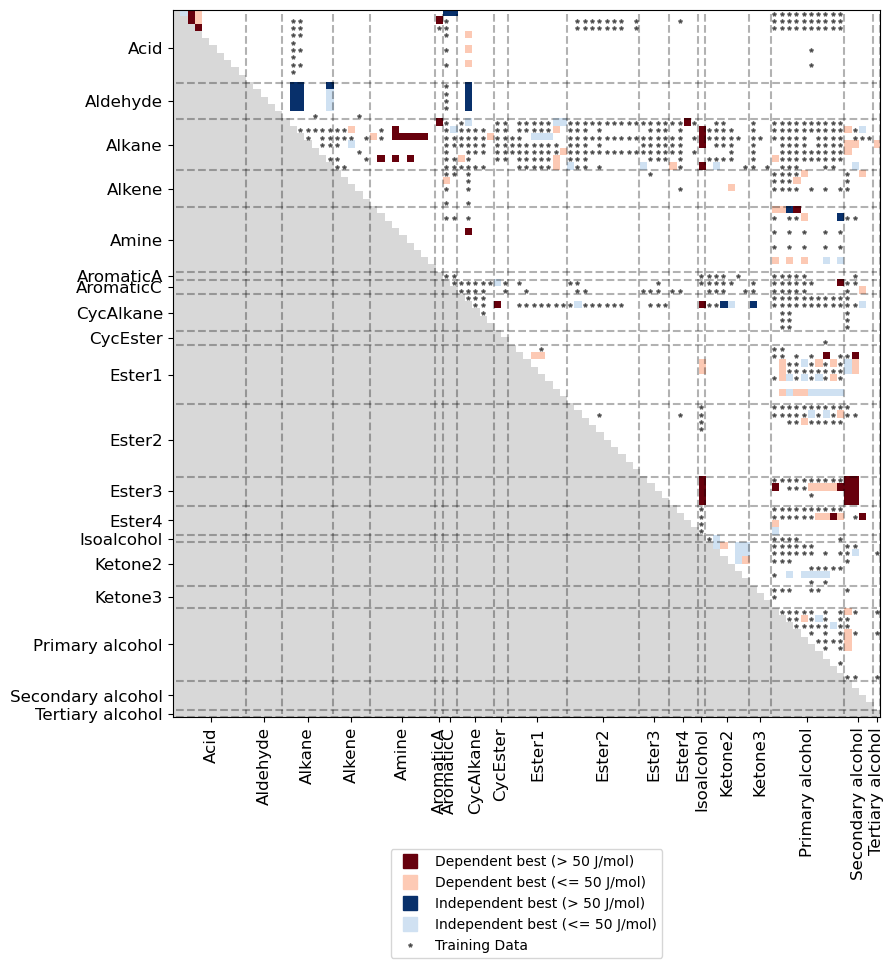

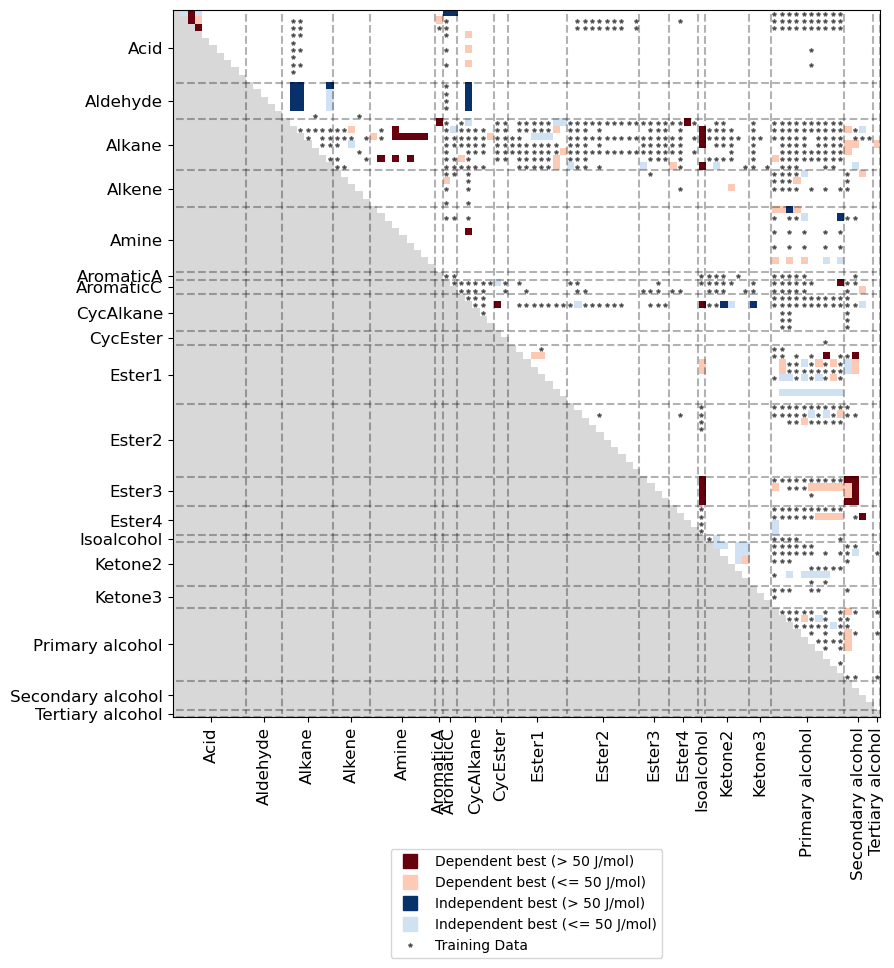

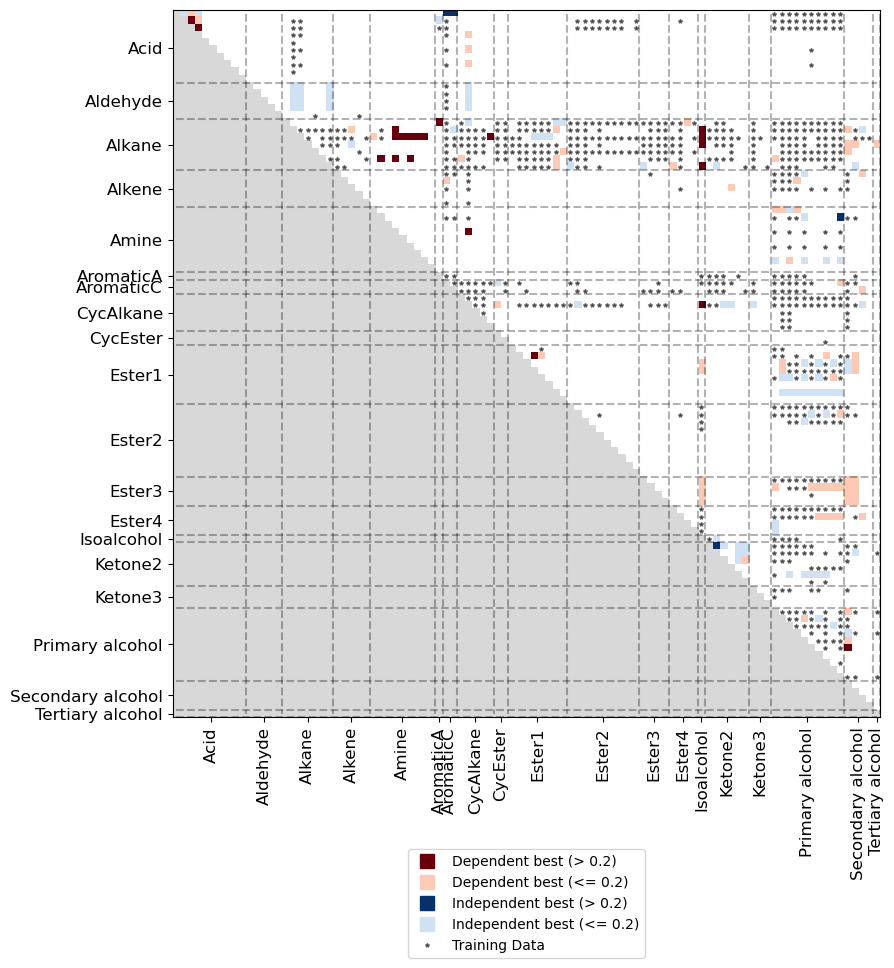

In [35]:
err_metrics = ['RMSE', 'MAE', 'MARE']
N = json.load(open(post_obj.data_file, 'r'))['N']
AE_MC = np.nan*np.eye(N)
AE_uni = np.nan*np.eye(N)

for err_metric in err_metrics:
    if err_metric == 'MARE':
        cutoff = 0.2
        legend_low = f'(<= {cutoff})'
        legend_high = f'(> {cutoff})'
    else:
        cutoff = 50
        legend_low = f'(<= {cutoff} J/mol)'
        legend_high = f'(> {cutoff} J/mol)'
        
    diff_metrics = np.array(all_err_metrics[err_metric][0] - all_err_metrics[err_metric][1])

    uni_best = diff_metrics>0
    MC_best = ~uni_best

    diff_metrics = np.abs(diff_metrics)
    diff_metrics[diff_metrics <= cutoff] = 0.2
    diff_metrics[diff_metrics > cutoff] = 1

    AE_MC[post_obj.testing_indices[MC_best,0], post_obj.testing_indices[MC_best,1]] = diff_metrics[MC_best]
    AE_uni[post_obj.testing_indices[uni_best,0], post_obj.testing_indices[uni_best,1]] = diff_metrics[uni_best]

    plt.figure(figsize=(10, 10))

    plt.plot(post_obj.Idx_known[:,1], post_obj.Idx_known[:,0], '*k', label='Training Data', alpha=0.5, markersize=3)
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), fontsize=12)

    plt.imshow(AE_MC, cmap='Reds', vmin=0, vmax=1, label='MC')
    plt.imshow(AE_uni, cmap='Blues', vmin=0, vmax=1, label='UNIFAC')

    A_grey = np.nan*np.eye(N)
    for i in range(N):
        for j in range(i,N):
            A_grey[j,i] = 0.25
        
    plt.imshow(A_grey, cmap='Greys',vmin=0,vmax=1)

    unique_fg, idx, counts = np.unique(post_obj.fg, return_index=True, return_counts=True)
    unique_fg = unique_fg[np.argsort(idx)]
    counts = counts[np.argsort(idx)]
    counts[0]=counts[0]-1
    counts = counts

    end_points = [0]
    for count in np.cumsum(counts):
        count += 0.5
        end_points += [count]
        plt.plot([count, count], [0, N-1], '--k', alpha=0.3)
        plt.plot([0, N-1], [count, count], '--k', alpha=0.3)

    mid_points = (np.array(end_points[:-1])+np.array(end_points[1:]))/2
    plt.xticks(mid_points, unique_fg, rotation=90, fontsize=12)
    plt.yticks(mid_points, unique_fg, fontsize=12)

    # Custom legend elements
    # Get colors from colormaps
    red_alpha_1 = cm.Reds(0.9999)  # Dark red
    red_alpha_2 = cm.Reds(0.2)  # Light red
    green_alpha_1 = cm.Blues(0.9999)  # Dark green
    green_alpha_2 = cm.Blues(0.2)  # Light green

    # Custom legend elements
    custom_lines = [
        Line2D([0], [0], marker='s', color=red_alpha_1, markersize=10, label=f'Dependent best {legend_high}', linestyle=''),
        Line2D([0], [0], marker='s', color=red_alpha_2, markersize=10, label=f'Dependent best {legend_low}', linestyle=''),
        Line2D([0], [0], marker='s', color=green_alpha_1, markersize=10, label=f'Independent best {legend_high}', linestyle=''),
        Line2D([0], [0], marker='s', color=green_alpha_2, markersize=10, label=f'Independent best {legend_low}', linestyle=''),
        Line2D([0], [0], marker='*', color='k', markersize=3, alpha=0.5, label='Training Data', linestyle=''),
    ]
    # Add legend to the plot
    plt.legend(handles=custom_lines, loc='lower center', bbox_to_anchor=(0.5, -0.35))

    plt.tight_layout()

    png_path = f'/home/garren/HPC Files/Pure_RK_Compare_T_and_T_indep_{err_metric}.png'

    plt.savefig(png_path, dpi=500)